<a href="https://colab.research.google.com/github/hrith/E.R.P-Dairy-Farm/blob/master/maskrcnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installation

In [ ]:
!git clone https://github.com/matterport/Mask_RCNN.git

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 125.23 MiB | 7.24 MiB/s, done.
Resolving deltas: 100% (560/560), done.


In [ ]:
%cd Mask_RCNN

/content/Mask_RCNN


In [ ]:
!pip install -r requirements.txt

     |████████████████████████████████| 204kB 14.1MB/s 
     |████████████████████████████████| 163kB 30.9MB/s 


In [ ]:
!python setup.py install

In [ ]:
!ls

assets	images	     mask_rcnn.egg-info  requirements.txt  setup.py
build	LICENSE      mrcnn		 samples
dist	MANIFEST.in  README.md		 setup.cfg


In [ ]:
!pip install tensorflow==1.15

In [ ]:
!pip install keras==2.3

# Windshield training code

In [ ]:
%cd ..

In [93]:
from mrcnn.config import Config
from mrcnn import model as modellib
from mrcnn import visualize
import mrcnn
from mrcnn.utils import Dataset
from mrcnn.model import MaskRCNN
import numpy as np
from numpy import zeros
from numpy import asarray
import colorsys
import argparse
import imutils
import random
import cv2
import os
import time
import json
from matplotlib import pyplot
from matplotlib.patches import Rectangle
from keras.models import load_model
%matplotlib inline
from os import listdir
from xml.etree import ElementTree

In [94]:
class WindShieldConfig(Config):
    NAME = "WindShield_config"
 
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
 
    NUM_CLASSES = 2+1
   
    STEPS_PER_EPOCH = 131
    
    LEARNING_RATE=0.006
    
    DETECTION_MIN_CONFIDENCE = 0.1
    
    MAX_GT_INSTANCES=10


In [95]:
config = WindShieldConfig()
# config.display()

In [ ]:
!wget https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5

In [107]:
class LoadDataset(Dataset):
    def load_dataset(self, dataset_dir, is_train=True):
        images_dir = "dataset"
        self.add_class(images_dir, 1, "head_light")
        self.add_class(images_dir, 2, "windshield")
        
        for filename in listdir(images_dir):
          fn = filename.split(".")
          if fn[-1] != "json":
            image_id = ".".join(fn[:-1])
            img_path = images_dir + "/" + filename
            ann_path = images_dir + "/" + image_id + '.json'
            self.add_image(images_dir, image_id=image_id, path=img_path, annotation=ann_path)

    def c_extract_ann_dt(self,ann_path):
      with open(ann_path) as f:
        ann_data = json.load(f)
        h = ann_data['imageHeight']
        w = ann_data['imageWidth']
        print(ann_path)
        classes = []
        masks = []
        for dt in ann_data["shapes"]:
          mask = zeros([h, w], dtype='uint8')
          polygon = np.array([[[int(coords[0]), int(coords[1])] for coords in dt["points"]]])
          cv2.fillPoly( mask, polygon, 255 )
          masks.append(mask)
          if dt["label"] == "head_light":
            classes.append(1)
          elif dt["label"] == "windshield":
            classes.append(2)
        return np.array(masks).reshape(h,w, len(classes)), classes

    def load_mask(self, image_id):
        info = self.image_info[image_id]
        path = info['annotation']
        masks, class_ids = self.c_extract_ann_dt(path)
        return masks, asarray(class_ids, dtype='int32')

    def image_reference(self, image_id):
        info = self.image_info[image_id]
        print(info)
        return info['path']

In [108]:
train_set = LoadDataset()
train_set.load_dataset("dataset", is_train=True)
train_set.prepare()
print("Train: %d" % len(train_set.image_ids))

test_set = LoadDataset()
test_set.load_dataset("dataset", is_train=False)
test_set.prepare()
print("Test: %d" % len(test_set.image_ids))

Train: 5
Test: 5


In [109]:
model = modellib.MaskRCNN(mode="training", config=config, model_dir='./')

In [110]:
model.load_weights('mask_rcnn_coco.h5', by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])

In [101]:
!pip install imgaug

In [111]:
from imgaug import augmenters as iaa

data_augmentation = iaa.Sequential([
    iaa.Crop(px=(0, 16)),
    iaa.Fliplr(0.5),
    iaa.Flipud(0.5),
    iaa.GaussianBlur(sigma=(0, 3.0)),
    iaa.AverageBlur(k=(2, 7)),
    iaa.MedianBlur(k=(3, 11)),
    iaa.LinearContrast((0.75, 1.5)),
    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
    iaa.Multiply((0.8, 1.2), per_channel=0.2),
    iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)),
    iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0)),
    iaa.EdgeDetect(alpha=(0, 0.7)),
    iaa.DirectedEdgeDetect(alpha=(0, 0.7), direction=(0.0, 1.0)),
    iaa.Invert(0.05, per_channel=True),
    iaa.Add((-10, 10), per_channel=0.5),
    iaa.Grayscale(alpha=(0.0, 1.0)),
    iaa.ElasticTransformation(alpha=(0.5, 3.5), sigma=0.25),
    iaa.Affine(
            scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
            translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
            rotate=(-45, 45),
            shear=(-16, 16),
            order=[0, 1],
            cval=(0, 255)),
    
], random_order=True)

In [ ]:
model.train(train_set, test_set, learning_rate=2*config.LEARNING_RATE, epochs=5, layers="heads")
history = model.keras_model.history.history


Starting at epoch 0. LR=0.012

Checkpoint Path: ./windshield_config20210105T1152/mask_rcnn_windshield_config_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn

/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multi

Epoch 1/5
dataset/car-5.json
dataset/car-5.json
dataset/car-5.json
dataset/car-5.json
dataset/car-3.json
dataset/car-3.json
dataset/car-3.json
dataset/car-3.json
dataset/car-1.json
dataset/car-1.json
dataset/car-1.json
dataset/car-1.json
dataset/car-4.json
dataset/car-4.json
dataset/car-4.json
dataset/car-4.json
dataset/car-2.json
dataset/car-2.json
dataset/car-2.json
dataset/car-2.json
dataset/car-2.json
dataset/car-2.json
dataset/car-2.json
dataset/car-2.json
dataset/car-3.json
dataset/car-3.json
dataset/car-3.json
dataset/car-3.json
dataset/car-1.json
dataset/car-1.json
dataset/car-1.json
dataset/car-1.json
dataset/car-5.json
dataset/car-5.json
dataset/car-5.json
dataset/car-5.json
dataset/car-4.json
dataset/car-4.json
dataset/car-4.json
dataset/car-4.json
dataset/car-4.json
dataset/car-4.json
dataset/car-4.json
dataset/car-4.json
dataset/car-2.json
dataset/car-2.json
dataset/car-2.json
dataset/car-2.json
dataset/car-1.json
dataset/car-1.json
dataset/car-1.json
dataset/car-5.json
da

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:709: UserWarning: An input could not be retrieved. It could be because a worker has died.We do not have any information on the lost sample.
  UserWarning)


dataset/car-5.json
 23/131 [====>.........................] - ETA: 16:25 - loss: 1.7380 - rpn_class_loss: 0.0019 - rpn_bbox_loss: 0.4044 - mrcnn_class_loss: 0.1069 - mrcnn_bbox_loss: 0.9689 - mrcnn_mask_loss: 0.2559

In [ ]:
import time
model_path = 'windshield.h5'
model.keras_model.save_weights(model_path)

#Inference code

In [ ]:
%cd samples

In [ ]:
!wget https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5

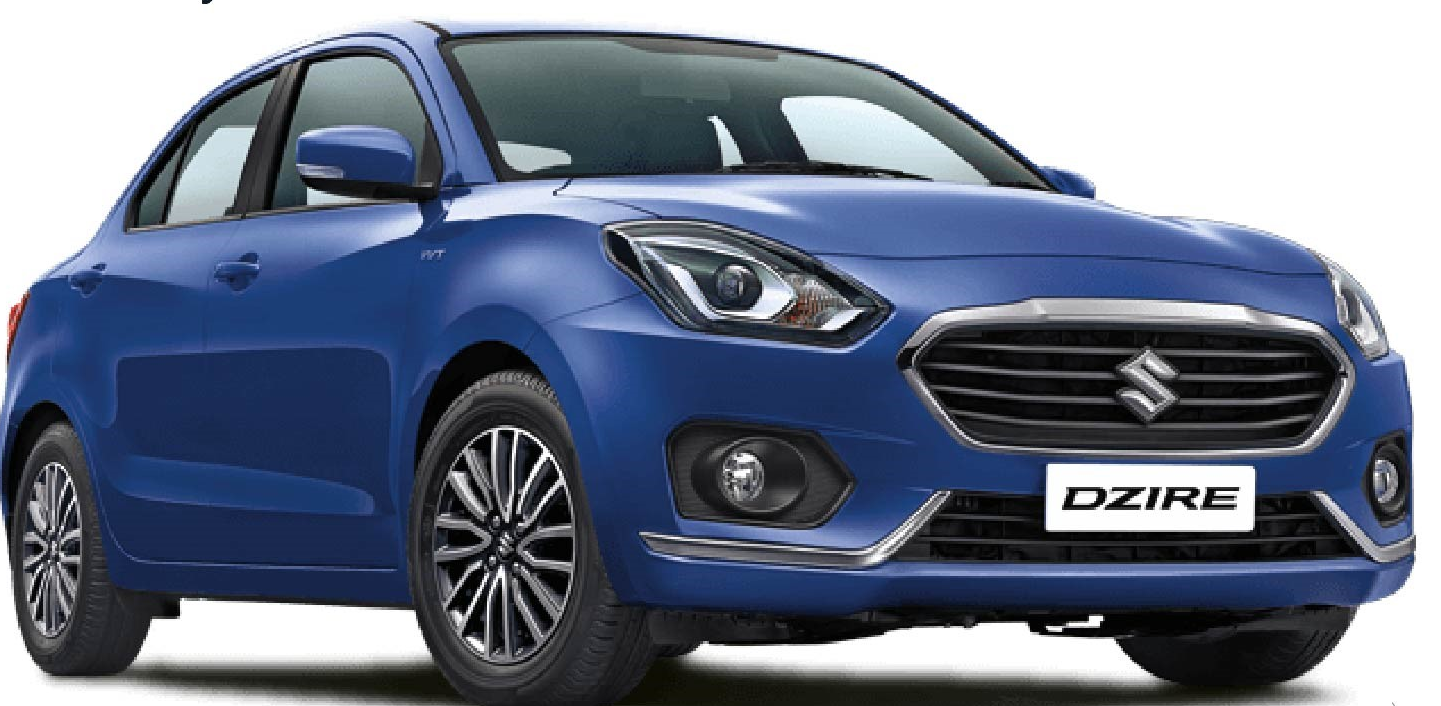

In [92]:
# example of inference with a pre-trained coco model
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
from matplotlib import pyplot
from matplotlib.patches import Rectangle
from google.colab.patches import cv2_imshow

def load_inf_model(path):
  model = MaskRCNN(mode='inference', model_dir='./', config=TestConfig())
  model.load_weights(path, by_name=True)
  return model

def draw_image_with_boxes(filename, boxes_list, classes_list):
     data = cv2.imread(filename)
     ids = [3,6,8]
     for i in range(len(boxes_list)):
          if classes_list[i] in ids:
            x1, y1, x2, y2 = boxes_list[i]
            img = data[x1:x2, y1:y2]
            windshield_detection = load_inf_model("windshield.h5")
            results = windshield_detection.detect([img], verbose=0)
            print(results)


class TestConfig(Config):
     NAME = "test"
     GPU_COUNT = 1
     IMAGES_PER_GPU = 1
     NUM_CLASSES = 1 + 80

img = load_img('dataset/car-1.jpg')
img = img_to_array(img)

car_detection = load_inf_model('mask_rcnn_coco.h5')
results = car_detection.detect([img], verbose=0)
draw_image_with_boxes('dataset/car-1.jpg', results[0]['rois'], results[0]['class_ids'])

dataset/car-1.jpg
(870, 1531, 3)
67 90 773 1531
(0, 0, 3)


error: ignored

In [ ]:
# example of inference with a pre-trained coco model
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
from matplotlib import pyplot
from matplotlib.patches import Rectangle

# draw an image with detected objects
def draw_image_with_boxes(filename, boxes_list):
     # load the image
     data = pyplot.imread(filename)
     # plot the image
     pyplot.imshow(data)
     # get the context for drawing boxes
     ax = pyplot.gca()
     # plot each box
     for box in boxes_list:
          # get coordinates
          y1, x1, y2, x2 = box
          # calculate width and height of the box
          width, height = x2 - x1, y2 - y1
          # create the shape
          rect = Rectangle((x1, y1), width, height, fill=False, color='red')
          # draw the box
          ax.add_patch(rect)
     # show the plot
     pyplot.show()

# define the test configuration
class TestConfig(Config):
     NAME = "test"
     GPU_COUNT = 1
     IMAGES_PER_GPU = 1
     NUM_CLASSES = 1 + 80

# define the model
rcnn = MaskRCNN(mode='inference', model_dir='./', config=TestConfig())
# load coco model weights
rcnn.load_weights('mask_rcnn_coco.h5', by_name=True)
# load photograph
img = load_img('sample2.jpg')
img = img_to_array(img)
# make prediction
results = rcnn.detect([img], verbose=0)
# visualize the results
draw_image_with_boxes('sample2.jpg', results[0]['rois'])